# Calibration sets analysis

Training Decision Tree...
Training Random Forest...
Training Logistic Regression...


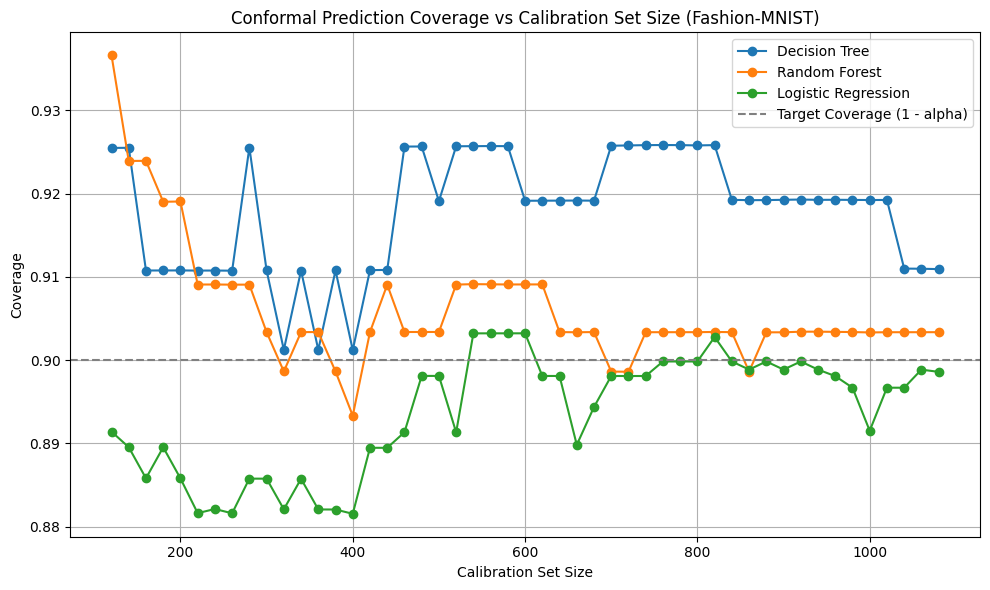

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_openml

# Load Fashion-MNIST from OpenML
fashion = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
X, y = fashion.data / 255.0, fashion.target.astype(int)  # Normalize and convert labels to int

# Split into train (40%) and test (60%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.6, stratify=y, random_state=42
)

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5),  # Shallow tree to reduce accuracy
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=0),
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
}

# Conformal prediction setup
alpha = 0.1
calib_sizes = []
for i in range(1, 50):
    calib_size = 100 + i*20
    calib_sizes.append(calib_size)
results = {name: {"calib_size": [], "coverage": []} for name in models}

# Score function: s(x, y) = 1 - P(y | x)
def score_function(probs, y_true):
    return 1 - probs[np.arange(len(y_true)), y_true]

# Conformal prediction coverage
def conformal_prediction(model, X_calib, y_calib, X_eval, y_eval, calib_size):
    probs_calib = model.predict_proba(X_calib)
    scores_calib = score_function(probs_calib, y_calib)
    quantile_index = int(np.ceil((calib_size + 1) * (1 - alpha))) - 1
    q_hat = np.sort(scores_calib)[min(quantile_index, len(scores_calib)-1)]

    probs_test = model.predict_proba(X_eval)
    prediction_sets = [np.where(1 - prob <= q_hat)[0] for prob in probs_test]
    coverage = np.mean([y_eval[i] in prediction_sets[i] for i in range(len(y_eval))])
    return coverage

# Train models and compute coverage for each calibration size
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    for calib_size in calib_sizes:
        X_calib, X_eval, y_calib, y_eval = train_test_split(
            X_test, y_test, train_size=calib_size, stratify=y_test, random_state=42
        )
        coverage = conformal_prediction(model, X_calib, y_calib, X_eval, y_eval, calib_size)
        results[name]["calib_size"].append(calib_size)
        results[name]["coverage"].append(coverage)

# Plot coverage vs calibration size
plt.figure(figsize=(10, 6))
for name in models:
    plt.plot(results[name]["calib_size"], results[name]["coverage"], marker='o', label=name)

plt.axhline(1 - alpha, color='gray', linestyle='--', label='Target Coverage (1 - alpha)')
plt.xlabel("Calibration Set Size")
plt.ylabel("Coverage")
plt.title("Conformal Prediction Coverage vs Calibration Set Size (Fashion-MNIST)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluating Decision Tree over 25 trials...
  Calibration size: 100
  Calibration size: 110
  Calibration size: 120
  Calibration size: 130
  Calibration size: 140
  Calibration size: 150
  Calibration size: 160
  Calibration size: 170
  Calibration size: 180
  Calibration size: 190
  Calibration size: 200
  Calibration size: 210
  Calibration size: 220
  Calibration size: 230
  Calibration size: 240
  Calibration size: 250
  Calibration size: 260
  Calibration size: 270
  Calibration size: 280
  Calibration size: 290
  Calibration size: 300
  Calibration size: 310
  Calibration size: 320
  Calibration size: 330
  Calibration size: 340
  Calibration size: 350
  Calibration size: 360
  Calibration size: 370
  Calibration size: 380
  Calibration size: 390
  Calibration size: 400
  Calibration size: 410
  Calibration size: 420
  Calibration size: 430
  Calibration size: 440
  Calibration size: 450
  Calibration size: 460
  Calibration size: 470
  Calibration size: 480
  Calibration size: 4

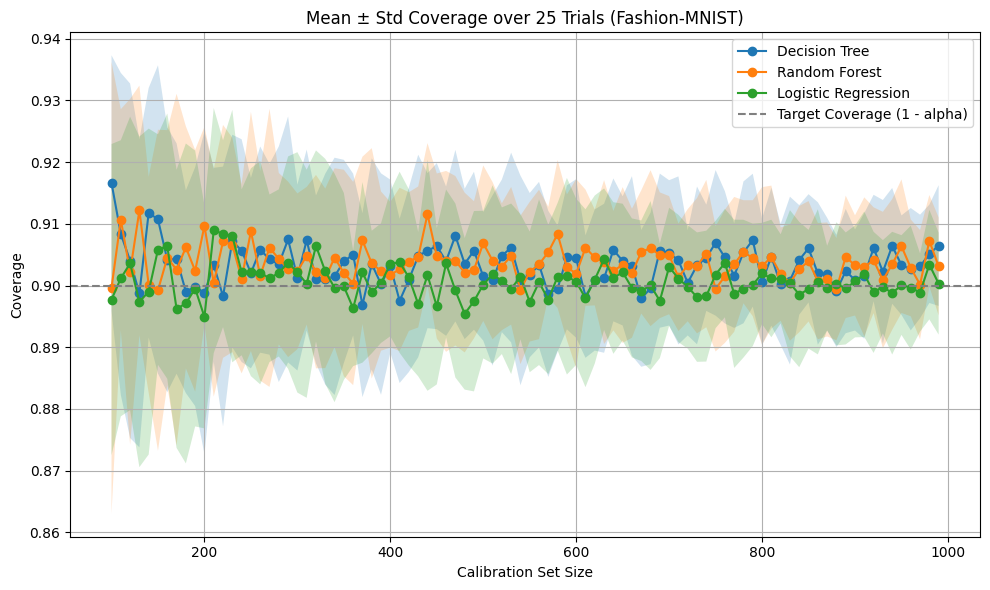

In [ ]:
import seaborn as sns

# Settings
num_trials =  25 # Number of repeated runs for averaging
calib_sizes = []
for i in range(90):
	calib_size = 100 + i*10
	calib_sizes.append(calib_size)
alpha = 0.1

# Storage for all trials
mean_coverage = {name: [] for name in models}
std_coverage = {name: [] for name in models}

# Repeat multiple trials for expected value estimation
for name, model in models.items():
    print(f"Evaluating {name} over {num_trials} trials...")
    for calib_size in calib_sizes:
        print("  Calibration size:", calib_size)
        coverages = []
        for _ in range(num_trials):
            X_calib, X_eval, y_calib, y_eval = train_test_split(
                X_test, y_test, train_size=calib_size, stratify=y_test
            )
            coverage = conformal_prediction(model, X_calib, y_calib, X_eval, y_eval, calib_size)
            coverages.append(coverage)

        mean_coverage[name].append(np.mean(coverages))
        std_coverage[name].append(np.std(coverages))

# Plot with shaded variance (1 std deviation)
plt.figure(figsize=(10, 6))
for name in models:
    means = np.array(mean_coverage[name])
    stds = np.array(std_coverage[name])
    plt.plot(calib_sizes, means, marker='o', label=name)
    plt.fill_between(calib_sizes, means - stds, means + stds, alpha=0.2)

plt.axhline(1 - alpha, color='gray', linestyle='--', label='Target Coverage (1 - alpha)')
plt.xlabel("Calibration Set Size")
plt.ylabel("Coverage")
plt.title(f"Mean ± Std Coverage over {num_trials} Trials (Fashion-MNIST)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


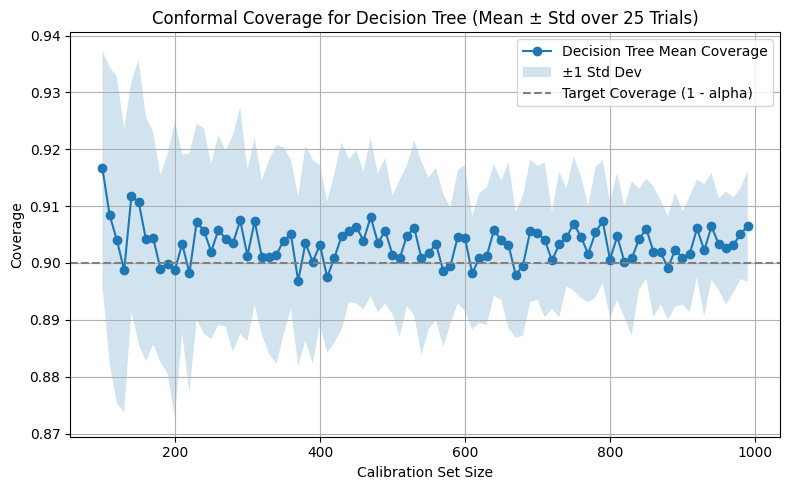

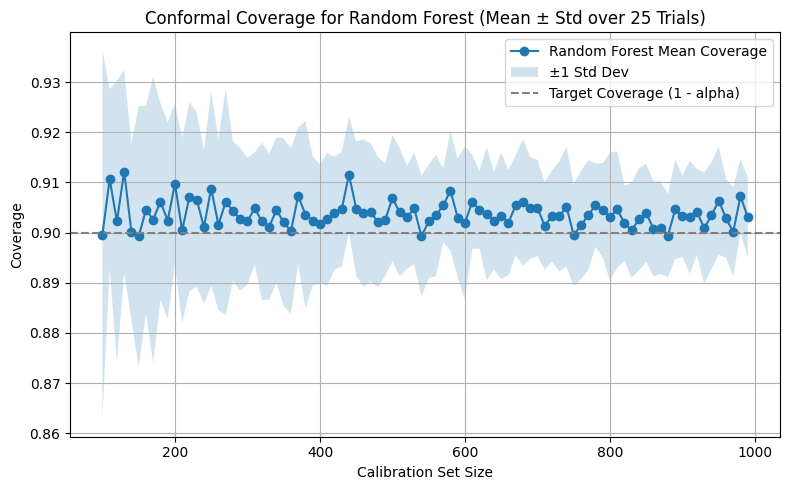

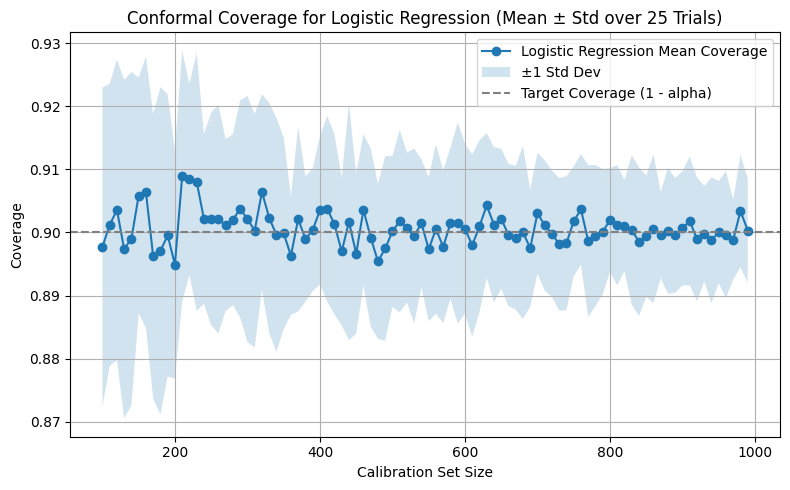

In [6]:
# Plot a separate figure for each model
for name in models:
    means = np.array(mean_coverage[name])
    stds = np.array(std_coverage[name])

    plt.figure(figsize=(8, 5))
    plt.plot(calib_sizes, means, marker='o', label=f'{name} Mean Coverage')
    plt.fill_between(calib_sizes, means - stds, means + stds, alpha=0.2, label='±1 Std Dev')
    plt.axhline(1 - alpha, color='gray', linestyle='--', label='Target Coverage (1 - alpha)')

    plt.xlabel("Calibration Set Size")
    plt.ylabel("Coverage")
    plt.title(f"Conformal Coverage for {name} (Mean ± Std over {num_trials} Trials)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


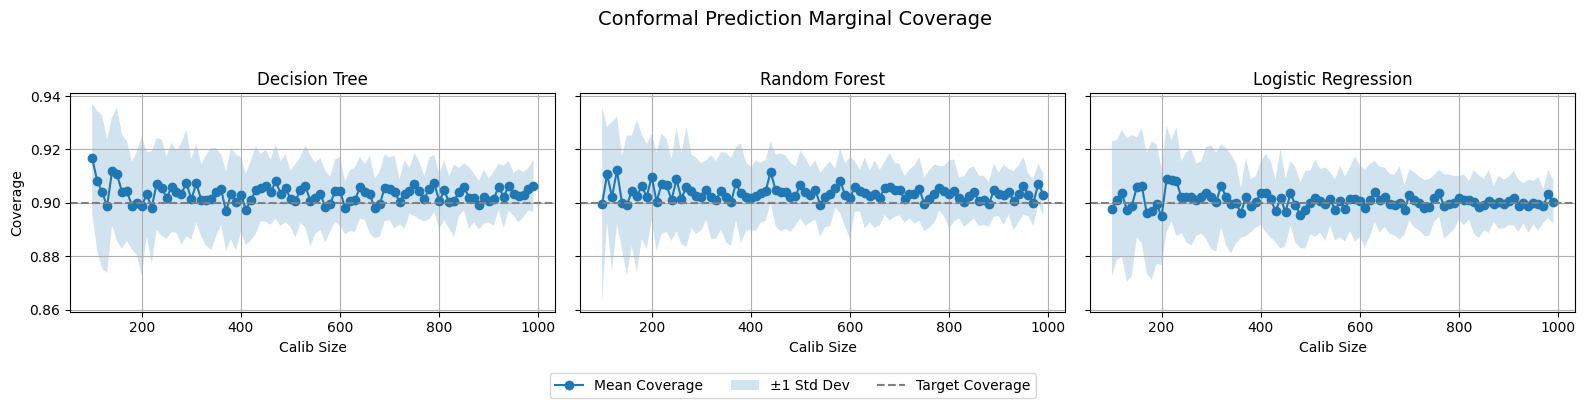

In [8]:
fig, axes = plt.subplots(1, len(models), figsize=(16, 4), sharey=True)

for ax, (name, model) in zip(axes, models.items()):
    means = np.array(mean_coverage[name])
    stds = np.array(std_coverage[name])

    ax.plot(calib_sizes, means, marker='o', label='Mean Coverage')
    ax.fill_between(calib_sizes, means - stds, means + stds, alpha=0.2, label='±1 Std Dev')
    ax.axhline(1 - alpha, color='gray', linestyle='--', label='Target Coverage')
    ax.set_title(name)
    ax.set_xlabel("Calib Size")
    ax.grid(True)
    if ax == axes[0]:
        ax.set_ylabel("Coverage")

fig.suptitle(f"Conformal Prediction Marginal Coverage", fontsize=14)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()
